In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Creating functions for curve_fit
def gaussian(x, amplitude, mu, sigma, y_offset):
    return amplitude * np.exp(-((x - mu)**2) / (2 * sigma**2)) + y_offset

def gaussian_fit(A, B, C, D, xdata, ydata):
    """
    A = Amplitude
    B = Mean
    C = Sigma
    D = Y Offset
    """
    popt, pcov = curve_fit(gaussian, xdata, ydata, 
                          p0=[A, B, C, D]) 

    amplitude, mean, sigma, vertical_offset = popt
    sigma_amp, sigma_mean, sigma_std, sigma_b = np.sqrt(np.diag(pcov))
    
    # Function automatically plots the data
    plt.scatter(xdata, ydata, label="Data", marker='.')
    plt.plot(xdata, gaussian(xdata, *popt), label="Best Fit", color="red")
    plt.legend()
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Current (mA)")
    plt.show()
    
    return amplitude, mean, sigma, vertical_offset, sigma_amp, sigma_mean, sigma_std, sigma_b

# Calibrating spectrometer using mercury data

Mercury has a known spectral line at a wavelength of 546.0735 nm. By using a tube of mercury plasma in front of the spectrometer, and while collecting atmospheric data to determine the index of refraction of the local air, we can calibrate the spectrometer to allow for more accurate results. We took data for the atmosphere's pressure, temperature, and humidity, and then used the NIST website to get an estimate for the index of refraction, n. As $\lambda_{air} = \lambda_{vac}/n$, we can then place the start and end wavelengths to scan at around one nanometer on either side of the expected $\lambda_{air}$ with an increment of 0.01 nms and an integration time of 0.05 seconds. 

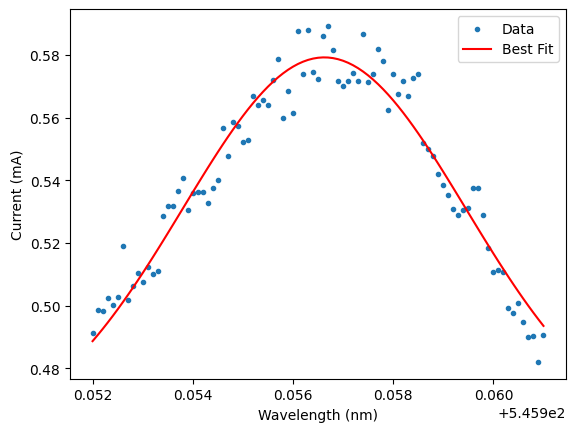

Mercury calibration fit:
Wavelength = 545.9566 nm +/- 3.8278e-05 nm
Amplitude: 0.1228 mA +/- 0.0129 mA
Sigma: 0.0028 +/- 0.0003
Y offset: 0.4565 mA +/- 0.0136 mA


In [3]:
# Calibrating Mercury Data
mercury = pd.read_csv("Hg-calibration.csv")

# set x and y axes
hg_wavelength = mercury.iloc[:, 0].values
hg_current = mercury.iloc[:, 1].values

# set cutoffs to make plot symmetrical
min_cutoff = 545.952
max_cutoff = 545.961
filtered_indices = (hg_wavelength >= min_cutoff) & (hg_wavelength <= max_cutoff)
filtered_wavelength = hg_wavelength[filtered_indices]
filtered_current = hg_current[filtered_indices]

# Estimates for gaussian function
A = 0.1
B = 545.957
C = 0.001
D = 0.4

amplitude, mean, sigma, vertical_offset, sigma_amp, sigma_mean, sigma_std, sigma_b = gaussian_fit(A, B, C, D, filtered_wavelength, filtered_current)
print(f'Mercury calibration fit:')
print(f'Wavelength = {mean:.4f} nm +/- {sigma_mean:.4e} nm')
print(f"Amplitude: {amplitude:.4f} mA +/- {sigma_amp:.4f} mA")
print(f'Sigma: {sigma:.4f} +/- {sigma_std:.4f}')
print(f"Y offset: {vertical_offset:.4f} mA +/- {sigma_b:.4f} mA")

After doing this fit, we were then able to calibrate the spectrometer in order to get more accurate data on the following H2D2 spectra.

# Estimating n (H-$\alpha$, 3 $\to$ 2)
In order to detect the first line in the Balmer Series, and each line afterwards, we first must find the index of refraction (n) given the atmospheric conditions at the time of our experiment. This step will be repeated for each new Balmer line in order to make it easier to find the spectra with the Horiba / Jobin-Yvon Spectrometer. After measuring the atmospheric pressure, relative humidity, and temperature, we can input our readings into the [NIST website](https://emtoolbox.nist.gov/Wavelength/Edlen.asp) once again and use the calculated value of n to estimate where we should expect to detect the hydrogen emission spectra. 

pressure = 0.8147 barr

humidity = 8.3%

temp = 21.6 C

n = 1.000217038

$\lambda_{vac}$ = 656.11224

$\lambda_{air}$ = 655.9698

From there, we can use the reduced mass Rydberg formula to estimate where we would be able to find the deuterium line. This is done using the ratio of the reduced masses between hydrogen and deuterium, as:
$$\frac{1}{\lambda}=R_{\infty}\frac{\mu}{m_e}((\frac{1}{n_1^2}-\frac{1}{n_2^2}))$$
Where:
$$\mu = \frac{m_e m_N}{m_e + m_N} = \frac{N_m}{1+N_m}$$
Here, $m_N$ is the mass of the nucleus and $N_m$ is then the number of electron masses that the nucleus mass could be described by. We can then find $\mu_H$ and $\mu_D$ before finding the releationship between $\lambda_H$ and $\lambda_D$ using:
$$\frac{1/\lambda_D}{1/\lambda_H}=\frac{\mu_D}{\mu_H} = \frac{\lambda_H}{\lambda_D} \to \lambda_D = \lambda_H \frac{\mu_H}{\mu_D}$$

Now, we can upload the data for this emission line and begin fitting a gaussian to our data. After doing the fits, we are then able to find a new and more accurate estimate for n which we can then use to transform our wavelength values to apply to the emission wavelength we would expect in a vacuum instead. This can be found as $n=\lambda_{vac}/\lambda_{air}$, and then we can simply do $\lambda_{Deuterium, vac}=\lambda_{Deuterium, air} \cdot n$

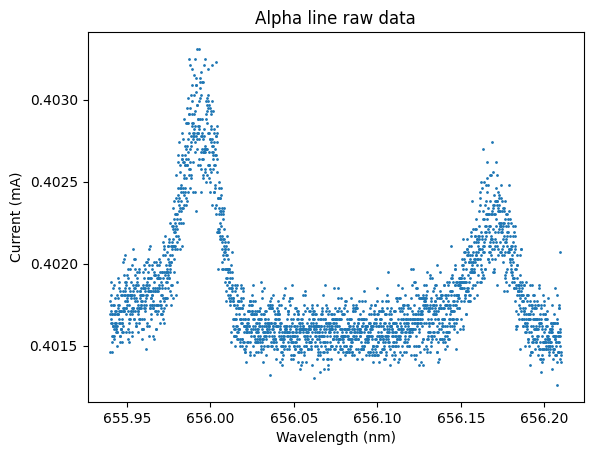

In [4]:
h2d2_alpha = pd.read_csv("h2d2-alpha3-2.csv", skiprows=0)

# set x and y axes
alpha_wavelength = h2d2_alpha.iloc[:, 0].values
alpha_current = h2d2_alpha.iloc[:, 1].values

plt.scatter(alpha_wavelength, alpha_current, s=1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Current (mA)')
plt.title('Alpha line raw data')
plt.savefig('Alpha line data.png')
plt.show()

Performing the reduced mass calculation, we can tell that our calibration is slightly off as the hydrogen emission line is showing up as the peak on the right between 656.15 to 656.20 nm. This could be related to an error in our calculation of the index of refraction or an error during our calibration step. No matter - as we can calculate the vacuum wavelength of the hydrogen line, we should be able to simply adjust the index of refraction to fit the data instead. Until we get to that step, let's first isolate each peak and fit them to a guassian curve in order to find the peak wavelength as well as the margins of error.

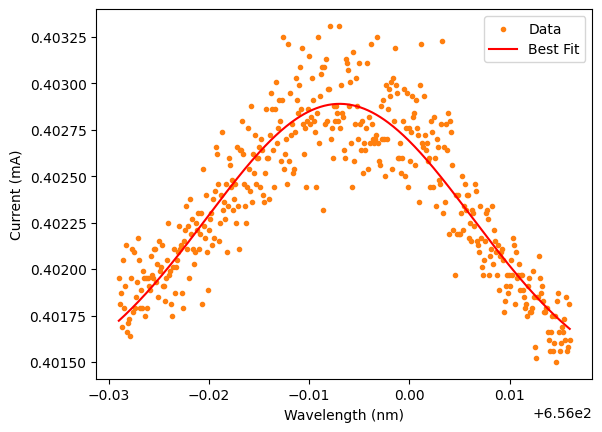

Deuterium Alpha Line:
Wavelength = 655.9930 nm +/- 1.5199e-04 nm
Amplitude: 0.0016 mA +/- 1.1252e-04 mA
Sigma: 0.0132 +/- 8.8427e-04
Y offset: 0.4013 mA +/- 1.1982e-04 mA


In [38]:
# Splitting data into Hydrogen and Deuterium
de_alpha_min_cutoff = 655.971
de_alpha_max_cutoff = 656.016

filtered_de_alpha_indices = (alpha_wavelength >= de_alpha_min_cutoff) & (alpha_wavelength <= de_alpha_max_cutoff)
filtered_de_alpha_wavelength = alpha_wavelength[filtered_de_alpha_indices]
filtered_de_alpha_current = alpha_current[filtered_de_alpha_indices]

# Deuterium alpha line first
plt.scatter(filtered_de_alpha_wavelength, filtered_de_alpha_current, s=1)
A_de = 0.00075
B_de = 656
C_de = 0.002
D_de = 0.402
de_alpha_amplitude, de_alpha_mean, de_alpha_sigma, de_alpha_vertical_offset, de_alpha_sigma_amp, de_alpha_sigma_mean, de_alpha_sigma_std, de_alpha_sigma_b = gaussian_fit(A_de, B_de, C_de, D_de, filtered_de_alpha_wavelength, filtered_de_alpha_current)
print(f'Deuterium Alpha Line:')
print(f'Wavelength = {de_alpha_mean:.4f} nm +/- {de_alpha_sigma_mean:.4e} nm')
print(f"Amplitude: {de_alpha_amplitude:.4f} mA +/- {de_alpha_sigma_amp:.4e} mA")
print(f'Sigma: {de_alpha_sigma:.4f} +/- {de_alpha_sigma_std:.4e}')
print(f"Y offset: {de_alpha_vertical_offset:.4f} mA +/- {de_alpha_sigma_b:.4e} mA")

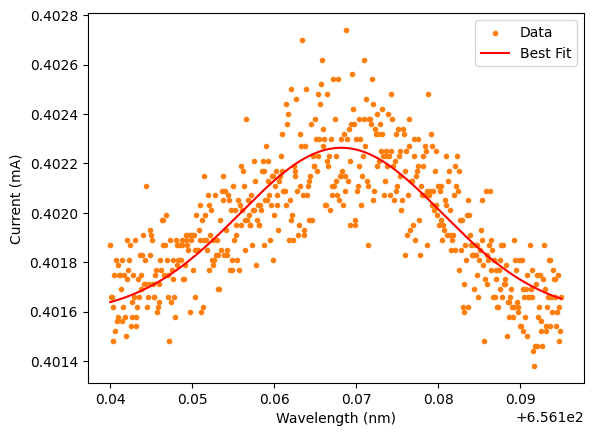

Hydrogen Alpha Line:
Wavelength = 656.1682 nm +/- 2.5820e-04 nm
Amplitude: 0.0007 mA +/- 3.1610e-05 mA
Sigma: 0.0123 +/- 7.3928e-04
Y offset: 0.4016 mA +/- 3.4518e-05 mA


In [39]:
# Hydrogen alpha line
he_alpha_min_cutoff = 656.14
he_alpha_max_cutoff = 656.195

filtered_he_alpha_indices = (alpha_wavelength >= he_alpha_min_cutoff) & (alpha_wavelength <= he_alpha_max_cutoff)
filtered_he_alpha_wavelength = alpha_wavelength[filtered_he_alpha_indices]
filtered_he_alpha_current = alpha_current[filtered_he_alpha_indices]

plt.scatter(filtered_he_alpha_wavelength, filtered_he_alpha_current, s=1)
A_he = 0.0012
B_he = 656.168
C_he = 0.003
D_he = 0.4009

he_alpha_amplitude, he_alpha_mean, he_alpha_sigma, he_alpha_vertical_offset, he_alpha_sigma_amp, he_alpha_sigma_mean, he_alpha_sigma_std, he_alpha_sigma_b = gaussian_fit(A_he, B_he, C_he, D_he, filtered_he_alpha_wavelength, filtered_he_alpha_current)
print(f'Hydrogen Alpha Line:')
print(f'Wavelength = {he_alpha_mean:.4f} nm +/- {he_alpha_sigma_mean:.4e} nm')
print(f"Amplitude: {he_alpha_amplitude:.4f} mA +/- {he_alpha_sigma_amp:.4e} mA")
print(f'Sigma: {he_alpha_sigma:.4f} +/- {he_alpha_sigma_std:.4e}')
print(f"Y offset: {he_alpha_vertical_offset:.4f} mA +/- {he_alpha_sigma_b:.4e} mA")

# Recalculating index of refraction
Now that we have calculated values for $\lambda_{He,air}$ and $\lambda_{De_air}$ as well as their uncertainties, we can use these values to recalculate the index of refraction. We can use the known/calculated values of the vacuum wavelengths of the helium lines, dividing them by the value that we calculated in order to adjust our n value:

$$n=\lambda_{vac}/\lambda_{air}$$

After finding this new value of n, we can multiply our calculated values for $\lambda_{He, air}$ and $\lambda_{De, air}$ to find their values in a vacuum. This step will be repeated for each of the Balmer series lines.

In [40]:
n_alpha = 656.11224/he_alpha_mean
print(f'n = {n_alpha}')
he_alpha_vac = he_alpha_mean * n_alpha
de_alpha_vac = de_alpha_mean * n_alpha
print(f'He alpha vacuum wavelength = {he_alpha_vac:.4f} nm +/- {he_alpha_sigma_mean:.4f} nm')
print(f'De alpha vacuum wavelength = {de_alpha_vac:.4f} nm +/- {de_alpha_sigma_mean:.4f} nm')

n = 0.9999147521826375
He alpha vacuum wavelength = 656.1122 nm +/- 0.0003 nm
De alpha vacuum wavelength = 655.9371 nm +/- 0.0002 nm


# Estimating n (H-$\beta$, 4 $\to$ 2)
pressure = 0.8147 barr

humidity = 9.8%

temp = 21.8 C

n = 1.000219315

$\lambda_{vac}$ = 486.0091

$\lambda_{air}$ = 485.902534

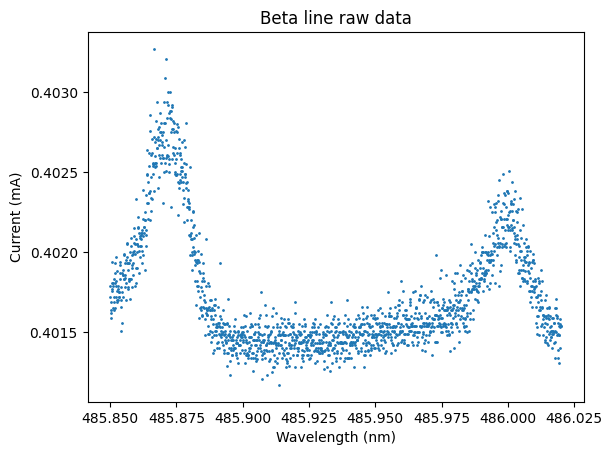

In [41]:
h2d2_beta = pd.read_csv("h2d2-beta4-2.csv", skiprows=0)

# set x and y axes
beta_wavelength = h2d2_beta.iloc[:, 0].values
beta_current = h2d2_beta.iloc[:, 1].values

plt.scatter(beta_wavelength, beta_current, s=1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Current (mA)')
plt.title('Beta line raw data')
plt.savefig('Beta line data.png')
plt.show()

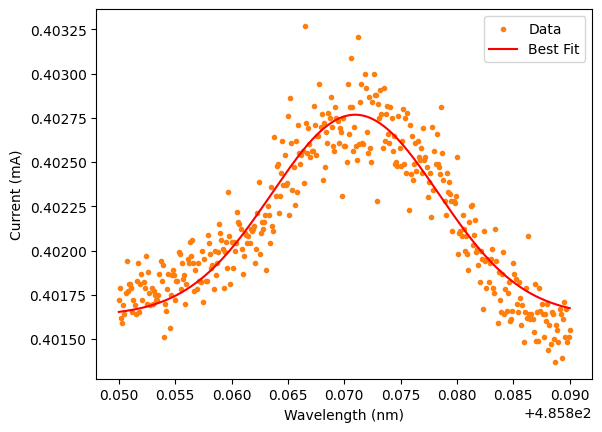

Deuterium Beta Line:
Wavelength = 485.8710 nm +/- 1.2459e-04 nm
Amplitude: 0.0011 mA +/- 2.5385e-05 mA
Sigma: 0.0074 +/- 2.4142e-04
Y offset: 0.4016 mA +/- 2.4935e-05 mA


In [42]:
# Splitting data into Hydrogen and Deuterium
de_beta_min_cutoff = 485.85
de_beta_max_cutoff = 485.89

filtered_de_beta_indices = (beta_wavelength >= de_beta_min_cutoff) & (beta_wavelength <= de_beta_max_cutoff)
filtered_de_beta_wavelength = beta_wavelength[filtered_de_beta_indices]
filtered_de_beta_current = beta_current[filtered_de_beta_indices]

plt.scatter(filtered_de_beta_wavelength, filtered_de_beta_current, s=1)
A_de = 0.0011
B_de = 485.874
C_de = 0.0002
D_de = 0.4015
de_beta_amplitude, de_beta_mean, de_beta_sigma, de_beta_vertical_offset, de_beta_sigma_amp, de_beta_sigma_mean, de_beta_sigma_std, de_beta_sigma_b = gaussian_fit(A_de, B_de, C_de, D_de, filtered_de_beta_wavelength, filtered_de_beta_current)
print(f'Deuterium Beta Line:')
print(f'Wavelength = {de_beta_mean:.4f} nm +/- {de_beta_sigma_mean:.4e} nm')
print(f"Amplitude: {de_beta_amplitude:.4f} mA +/- {de_beta_sigma_amp:.4e} mA")
print(f'Sigma: {de_beta_sigma:.4f} +/- {de_beta_sigma_std:.4e}')
print(f"Y offset: {de_beta_vertical_offset:.4f} mA +/- {de_beta_sigma_b:.4e} mA")

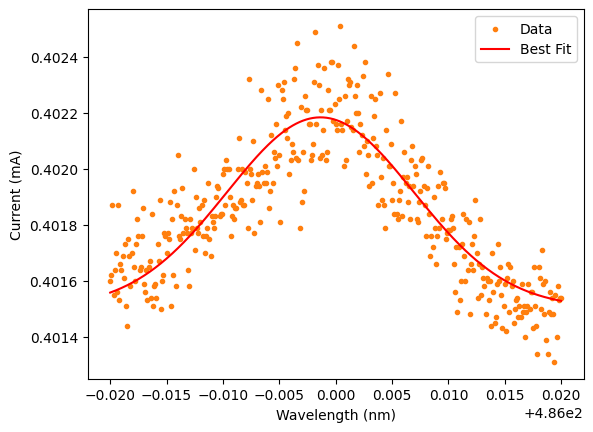

Hydrogen Beta Line:
Wavelength = 485.9986 nm +/- 1.7658e-04 nm
Amplitude: 0.0007 mA +/- 2.4676e-05 mA
Sigma: 0.0083 +/- 4.1317e-04
Y offset: 0.4015 mA +/- 2.6115e-05 mA


In [43]:
# Deuterium beta line
he_beta_min_cutoff = 485.98
he_beta_max_cutoff = 486.08

filtered_he_beta_indices = (beta_wavelength >= he_beta_min_cutoff) & (beta_wavelength <= he_beta_max_cutoff)
filtered_he_beta_wavelength = beta_wavelength[filtered_he_beta_indices]
filtered_he_beta_current = beta_current[filtered_he_beta_indices]

plt.scatter(filtered_he_beta_wavelength, filtered_he_beta_current, s=1)
A_he = 9e-4
B_he = 486
C_he = 0.0003
D_he = 0.4014
he_beta_amplitude, he_beta_mean, he_beta_sigma, he_beta_vertical_offset, he_beta_sigma_amp, he_beta_sigma_mean, he_beta_sigma_std, he_beta_sigma_b = gaussian_fit(A_he, B_he, C_he, D_he, filtered_he_beta_wavelength, filtered_he_beta_current)
print(f'Hydrogen Beta Line:')
print(f'Wavelength = {he_beta_mean:.4f} nm +/- {he_beta_sigma_mean:.4e} nm')
print(f"Amplitude: {he_beta_amplitude:.4f} mA +/- {he_beta_sigma_amp:.4e} mA")
print(f'Sigma: {he_beta_sigma:.4f} +/- {he_beta_sigma_std:.4e}')
print(f"Y offset: {he_beta_vertical_offset:.4f} mA +/- {he_beta_sigma_b:.4e} mA")

In [49]:
n_beta = 486.0091/he_beta_mean
print(f'n = {n_beta}')
he_beta_vac = he_beta_mean * n_beta
de_beta_vac = de_beta_mean * n_beta
print(f'He beta vacuum wavelength = {he_beta_vac:.4f} nm +/- {he_beta_sigma_mean:.4f} nm')
print(f'De beta vacuum wavelength = {de_beta_vac:.4f} nm +/- {de_beta_sigma_mean:.4f} nm')

n = 1.0000215037535398
He beta vacuum wavelength = 486.0091 nm +/- 0.0002 nm
De beta vacuum wavelength = 485.8814 nm +/- 0.0001 nm


# Estimating n (H-$\gamma$, 5 $\to$ 2)

pressure = 0.8154 barr

humidity = 7.5

temp = 21.5 C

n = 1.000222019

$\lambda_{vac}$ = 434.0472

$\lambda_{air}$ = 433.9509

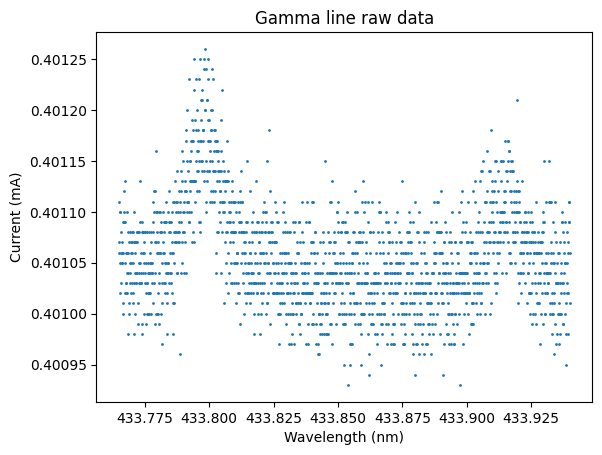

In [45]:
h2d2_gamma = pd.read_csv("h2d2-gamma5-2.csv", skiprows=0)

# set x and y axes
gamma_wavelength = h2d2_gamma.iloc[:, 0].values
gamma_current = h2d2_gamma.iloc[:, 1].values

plt.scatter(gamma_wavelength, gamma_current, s=1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Current (mA)')
plt.title('Gamma line raw data')
plt.savefig('Gamma line data.png')
plt.show()

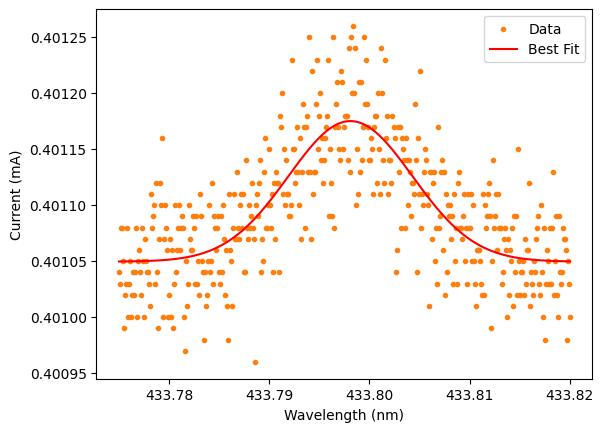

Deterium Gamma Line:
Wavelength = 433.7981 nm +/- 2.5716e-04 nm
Amplitude: 0.0001 mA +/- 5.1404e-06 mA
Sigma: 0.0062 +/- 3.5258e-04
Y offset: 0.4010 mA +/- 3.4778e-06 mA


In [46]:
# Deuterium line
de_gamma_min_cutoff = 433.775
de_gamma_max_cutoff = 433.82

filtered_de_gamma_indices = (gamma_wavelength >= de_gamma_min_cutoff) & (gamma_wavelength <= de_gamma_max_cutoff)
filtered_de_gamma_wavelength = gamma_wavelength[filtered_de_gamma_indices]
filtered_de_gamma_current = gamma_current[filtered_de_gamma_indices]

plt.scatter(filtered_de_gamma_wavelength, filtered_de_gamma_current, s=1)
A_de = 2.3e-4
B_de = 433.8
C_de = 0.0063
D_de = 0.4009

de_gamma_amplitude, de_gamma_mean, de_gamma_sigma, de_gamma_vertical_offset, de_gamma_sigma_amp, de_gamma_sigma_mean, de_gamma_sigma_std, de_gamma_sigma_b = gaussian_fit(A_de, B_de, C_de, D_de, filtered_de_gamma_wavelength, filtered_de_gamma_current)
print(f'Deterium Gamma Line:')
print(f'Wavelength = {de_gamma_mean:.4f} nm +/- {de_gamma_sigma_mean:.4e} nm')
print(f"Amplitude: {de_gamma_amplitude:.4f} mA +/- {de_gamma_sigma_amp:.4e} mA")
print(f'Sigma: {de_gamma_sigma:.4f} +/- {de_gamma_sigma_std:.4e}')
print(f"Y offset: {de_gamma_vertical_offset:.4f} mA +/- {de_gamma_sigma_b:.4e} mA")

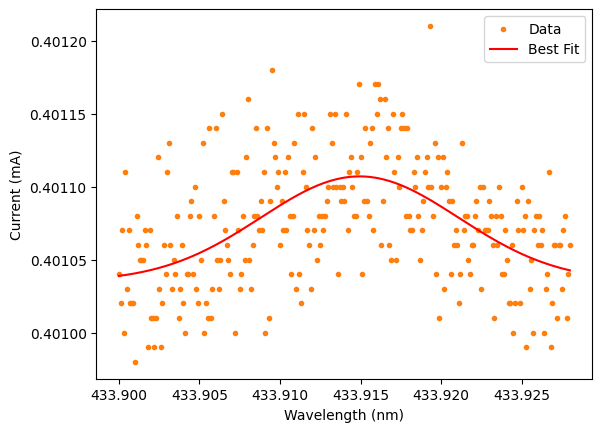

Hydrogen Gamma Line:
Wavelength = 433.9149 nm +/- 4.2909e-04 nm
Amplitude: 0.0001 mA +/- 1.0025e-05 mA
Sigma: 0.0061 +/- 1.1227e-03
Y offset: 0.4010 mA +/- 1.0824e-05 mA


In [47]:
# Hydrogen line
he_gamma_min_cutoff = 433.9
he_gamma_max_cutoff = 433.928

filtered_he_gamma_indices = (gamma_wavelength >= he_gamma_min_cutoff) & (gamma_wavelength <= he_gamma_max_cutoff)
filtered_he_gamma_wavelength = gamma_wavelength[filtered_he_gamma_indices]
filtered_he_gamma_current = gamma_current[filtered_he_gamma_indices]

plt.scatter(filtered_he_gamma_wavelength, filtered_he_gamma_current, s=1)
A_he = 0.0002
B_he = 433.915
C_he = 1e-3
D_he = 0.401

he_gamma_amplitude, he_gamma_mean, he_gamma_sigma, he_gamma_vertical_offset, he_gamma_sigma_amp, he_gamma_sigma_mean, he_gamma_sigma_std, he_gamma_sigma_b = gaussian_fit(A_he, B_he, C_he, D_he, filtered_he_gamma_wavelength, filtered_he_gamma_current)
print(f'Hydrogen Gamma Line:')
print(f'Wavelength = {he_gamma_mean:.4f} nm +/- {he_gamma_sigma_mean:.4e} nm')
print(f"Amplitude: {he_gamma_amplitude:.4f} mA +/- {he_gamma_sigma_amp:.4e} mA")
print(f'Sigma: {he_gamma_sigma:.4f} +/- {he_gamma_sigma_std:.4e}')
print(f"Y offset: {he_gamma_vertical_offset:.4f} mA +/- {he_gamma_sigma_b:.4e} mA")

In [48]:
n_gamma = 434.0472/he_gamma_mean
print(f'n = {n_gamma}')
he_gamma_vac = he_gamma_mean * n_gamma
de_gamma_vac = de_gamma_mean * n_gamma
print(f'He gamma vacuum wavelength = {he_gamma_vac:.4f} nm +/- {he_gamma_sigma_mean:.4f} nm')
print(f'De gamma vacuum wavelength = {de_gamma_vac:.4f} nm +/- {de_gamma_sigma_mean:.4f} nm')

n = 1.0003047948503587
He gamma vacuum wavelength = 434.0472 nm +/- 0.0004 nm
De gamma vacuum wavelength = 433.9303 nm +/- 0.0003 nm


# Linearizing data
After we have finished getting measurements of our H2D2 emission wavelengths, we can begin to show a correspondence between the wavelength and which orbital the electron drops from. We can do this by introducing the **Rydberg Constant**. For this calculation, it is vital to utilize the value of the **wavenumber**, the inverse of the wavelength, $1/\lambda$, as light's wavenumber is proportional to its quantized energy, E, giving us the formula:
$$\frac{1}{\lambda}=\frac{E}{hc}$$
Where $h$ is the Planck constant ($4.135667 x 10^{-15} eV \cdot Hz^{-1}$), and $c$ is the speed of light in a vacuum (299792458 m/s). For the Balmer Series, the Rydberg constant then can be found as:
$$\frac{1}{\lambda}=R(\frac{1}{n_f^2}-\frac{1}{n_i^2}) = \frac{R}{4}-\frac{R}{n_i^2}$$
Here, $n_i$ refers to the orbital that an electron drops from, while $n_f$ refers to the orbital that an electron drops *to*. As shown above, we have data from the orbital transitions for H-$\alpha$, H-$\beta$, and H-$\gamma$, where the electrons transitions from the orbitals 3 $\to$ 2, 4 $\to$ 2, and 5 $\to$ 2 respectively. With the discovered wavelengths, we can now plot the inverses of the wavelengths against 1/$N^2$, where N = $n_i$. This should result in a linear formula of the form:
$$y=mx+b$$
Where $y=\frac{1}{\lambda}$, $m=-R$, $x=\frac{1}{N^2}$, and $b=\frac{R}{4}$

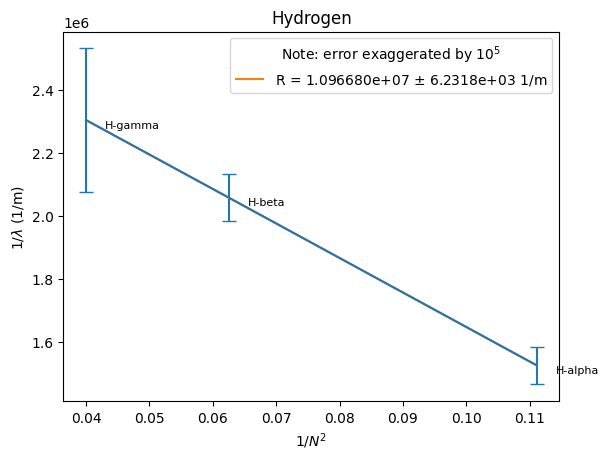

Equation of the line: 1/lambda = -10966800.66458x + 2742743.82995


In [50]:
from scipy.stats import linregress

def linear_function(x, m, b):
    return (m*x)+b

# Setting hydrogen plot
# convert nm to m - Rydberg units of 1/m
he_alpha_vac_m = he_alpha_vac*1e-9
he_alpha_sigma_mean_m = he_alpha_sigma_mean*1e-9
he_alpha_mean_m = he_alpha_mean*1e-9

he_beta_vac_m = he_beta_vac*1e-9
he_beta_sigma_mean_m = he_beta_sigma_mean*1e-9
he_beta_mean_m = he_beta_mean*1e-9

he_gamma_vac_m = he_gamma_vac*1e-9
he_gamma_sigma_mean_m = he_gamma_sigma_mean*1e-9
he_gamma_mean_m = he_gamma_mean*1e-9

y_he_vector = [1/he_alpha_vac_m, 1/he_beta_vac_m, 1/he_gamma_vac_m]
x_he_vector = [1/9, 1/16, 1/25] # 1/N^2

he_y_uncertainty_vector = np.array([he_alpha_sigma_mean_m/(he_alpha_mean_m**2), 
                                    he_beta_sigma_mean_m/(he_beta_mean_m**2), 
                                    he_gamma_sigma_mean_m/(he_gamma_mean_m**2)])
he_labels = ['H-alpha', 'H-beta', 'H-gamma']
for x, y, label in zip(x_he_vector, y_he_vector, he_labels):
    plt.text(x+0.003, y+0.00001, label, fontsize=8, ha='left', va='top')

h_slope, intercept, r_value, p_value, h_std_err = linregress(x_he_vector, y_he_vector)

# Generate fitted line points
x_fit = np.linspace(min(x_he_vector), max(x_he_vector), 100)
y_fit = linear_function(x_fit, h_slope, intercept)

plt.errorbar(x_he_vector, y_he_vector, yerr=he_y_uncertainty_vector*1e5, 
             fmt='-', capsize=5)
plt.plot(x_he_vector, y_he_vector, label=f"R = {-h_slope:.6e} $\pm$ {h_std_err:.4e} 1/m")
plt.title(f'Hydrogen')
plt.ylabel(f'1/$\lambda$ (1/m)')
plt.xlabel(f'1/$N^2$')
plt.legend(title="Note: error exaggerated by $10^5$")
plt.savefig('h series rydberg.png')
plt.show()

print(f"Equation of the line: 1/lambda = {h_slope:.5f}x + {intercept:.5f}")


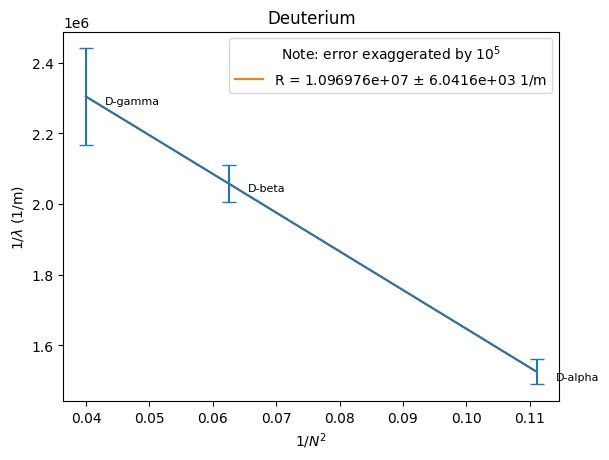

Equation of the line: 1/lambda = -10969764.40605x + 2743477.58608
Rydberg constant (from slope): 1.096976e+07 +/- 6.0416e+03


In [51]:
# Setting deuterium plot
# convert nm to m - Rydberg units of 1/m
de_alpha_vac_m = de_alpha_vac*1e-9
de_alpha_sigma_mean_m = de_alpha_sigma_mean*1e-9
de_alpha_mean_m = de_alpha_mean*1e-9

de_beta_vac_m = de_beta_vac*1e-9
de_beta_sigma_mean_m = de_beta_sigma_mean*1e-9
de_beta_mean_m = de_beta_mean*1e-9

de_gamma_vac_m = de_gamma_vac*1e-9
de_gamma_sigma_mean_m = de_gamma_sigma_mean*1e-9
de_gamma_mean_m = de_gamma_mean*1e-9

y_de_vector = [1/de_alpha_vac_m, 1/de_beta_vac_m, 1/de_gamma_vac_m]
x_de_vector = [1/9, 1/16, 1/25] # 1/N^2

de_y_uncertainty_vector = np.array([de_alpha_sigma_mean_m/(de_alpha_mean_m**2), 
                                    de_beta_sigma_mean_m/(de_beta_mean_m**2), 
                                    de_gamma_sigma_mean_m/(de_gamma_mean_m**2)])
de_labels = ['D-alpha', 'D-beta', 'D-gamma']
for x, y, label in zip(x_de_vector, y_de_vector, de_labels):
    plt.text(x+0.003, y+0.00001, label, fontsize=8, ha='left', va='top')

d_slope, intercept, r_value, p_value, d_std_err = linregress(x_de_vector, y_de_vector)

# Generate fitted line points
x_fit = np.linspace(min(x_de_vector), max(x_de_vector), 100)
y_fit = linear_function(x_fit, d_slope, intercept)

plt.errorbar(x_de_vector, y_de_vector, yerr=de_y_uncertainty_vector*1e5, fmt='-', capsize=5)
plt.plot(x_de_vector, y_de_vector, label=f"R = {-d_slope:.6e} $\pm$ {d_std_err:.4e} 1/m")
plt.title(f'Deuterium')
plt.ylabel(f'1/$\lambda$ (1/m)')
plt.xlabel(f'1/$N^2$')
plt.legend(title="Note: error exaggerated by $10^5$")
plt.savefig('d series rydberg.png')
plt.show()

print(f"Equation of the line: 1/lambda = {d_slope:.5f}x + {intercept:.5f}")
print(f'Rydberg constant (from slope): {-d_slope:.6e} +/- {d_std_err:.4e}')

In [53]:
print(f'Rydberg constant (H) = {-h_slope:.2f} +/- {h_std_err:.2f} 1/m')
print(f'Rydberg constant (D) = {-d_slope:.2f} +/- {d_std_err:.2f} 1/m')

Rydberg constant (H) = 10966800.66 +/- 6231.82 1/m
Rydberg constant (D) = 10969764.41 +/- 6041.58 1/m
